# Import Required Libraries
Import the necessary libraries, including pandas, numpy, and matplotlib.

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define Isolation Tree Structure
Define the structure of the isolation tree, which is the basic building block of the Isolation Forest algorithm.

In [9]:
# Define the structure of the Isolation Tree
class Node:
    pass

class ExNode(Node):
    def __init__(self, size):
        super().__init__()
        self.size = size

class InNode:
    def __init__(self, left, right, split_feature, split_value):
        super().__init__()
        self.left = left
        self.right = right
        self.split_feature = split_feature
        self.split_value = split_value

In [25]:
# Define the Isolation Tree
def c(size: int) -> float:
    EULER_MASCHERONI_CONSTANT = 0.5772156649
    if size > 2:
        return 2.0 * (np.log(size - 1) + EULER_MASCHERONI_CONSTANT) - 2.0 * (size - 1.) / size
    if size == 2:
        return 1
    return 0

class IsolationTree:
    def __init__(self, height_limit):
        self.height_limit = height_limit

    def fit(self, X: np.ndarray):
        _, self.num_features = X.shape
        self.root = self._build_tree(X, 0)

    def _build_tree(self, X: np.ndarray, current_height: int):
        num_samples, num_features = X.shape
        if num_samples == 0 or current_height == self.height_limit:
            return ExNode(num_samples)

        split_feature = np.random.choice(num_features)
        split_value = np.random.uniform(min(X[:, split_feature]), max(X[:, split_feature]))

        left_mask = X[:, split_feature] < split_value
        X_left, X_right = X[left_mask], X[~left_mask]

        return InNode(
            self._build_tree(X_left, current_height + 1),
            self._build_tree(X_right, current_height + 1),
            split_feature,
            split_value
        )

    def path_length(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._path_length(x, self.root, 0) for x in X])

    def _path_length(self, x: np.ndarray, node, current_height: int):
        if isinstance(node, ExNode):
            return current_height + c(node.size)

        split_feature, split_value = node.split_feature, node.split_value
        if x[split_feature] < split_value:
            return self._path_length(x, node.left, current_height + 1)
        else:
            return self._path_length(x, node.right, current_height + 1)

In [30]:
foo = np.random.normal(0, 1, (1000, 2))
tree = IsolationTree(height_limit=3)
tree.fit(foo)
tree.path_length(foo[:5])

array([12.98661232, 13.91548949, 13.9432294 , 13.9432294 , 13.9432294 ])

# Implement Isolation Forest Algorithm
Implement the Isolation Forest algorithm, which uses isolation trees to isolate anomalies.

In [49]:
# Define the Isolation Forest
class IsolationForest:
    def __init__(self, num_trees=100, max_subsample_size=np.inf, height_limit=8):
        self.num_trees = num_trees
        self.height_limit = height_limit
        self.max_subsample_size = max_subsample_size
        self.trees = []

    def fit(self, X: np.ndarray):
        num_samples = X.shape[0]
        subsample_size = min(self.max_subsample_size, num_samples)

        for _ in range(self.num_trees):
            ixs = np.random.choice(num_samples, subsample_size, replace=False)
            tree = IsolationTree(self.height_limit)
            tree.fit(X[ixs])
            self.trees.append(tree)

    def anomaly_score(self, X: np.ndarray) -> np.ndarray:
        num_samples = X.shape[0]
        path_lengths = np.zeros((num_samples, self.num_trees))

        for i, tree in enumerate(self.trees):
            path_lengths[:, i] = tree.path_length(X)

        return 2 ** (-path_lengths.mean(axis=1) / c(num_samples))

    # Function to predict if a data point is an outlier or not
    def predict(self, X, threshold=0.5):
        return [1 if score > threshold else 0 for score in self.anomaly_score(X)]

In [50]:
foo = np.random.normal(0, 1, (1000, 2))
forest = IsolationForest(num_trees=100, max_subsample_size=100, height_limit=3)
forest.fit(foo)
forest.anomaly_score(foo[:5])

array([0.05485987, 0.0610354 , 0.06511059, 0.07559743, 0.08659378])

# Load and Preprocess Time Series Data
Load the time series data and preprocess it for anomaly detection.

In [51]:
taxi_df = pd.read_csv("https://zenodo.org/record/4276428/files/STUMPY_Basics_Taxi.csv?download=1")
taxi_df['value'] = taxi_df['value'].astype(np.float64)
taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'])
taxi_df.head()

/tmp/ipykernel_110172/2642766164.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'])


,timestamp,value
0,2014-10-01 00:00:00,12751.0
1,2014-10-01 00:30:00,8767.0
2,2014-10-01 01:00:00,7005.0
3,2014-10-01 01:30:00,5257.0
4,2014-10-01 02:00:00,4189.0


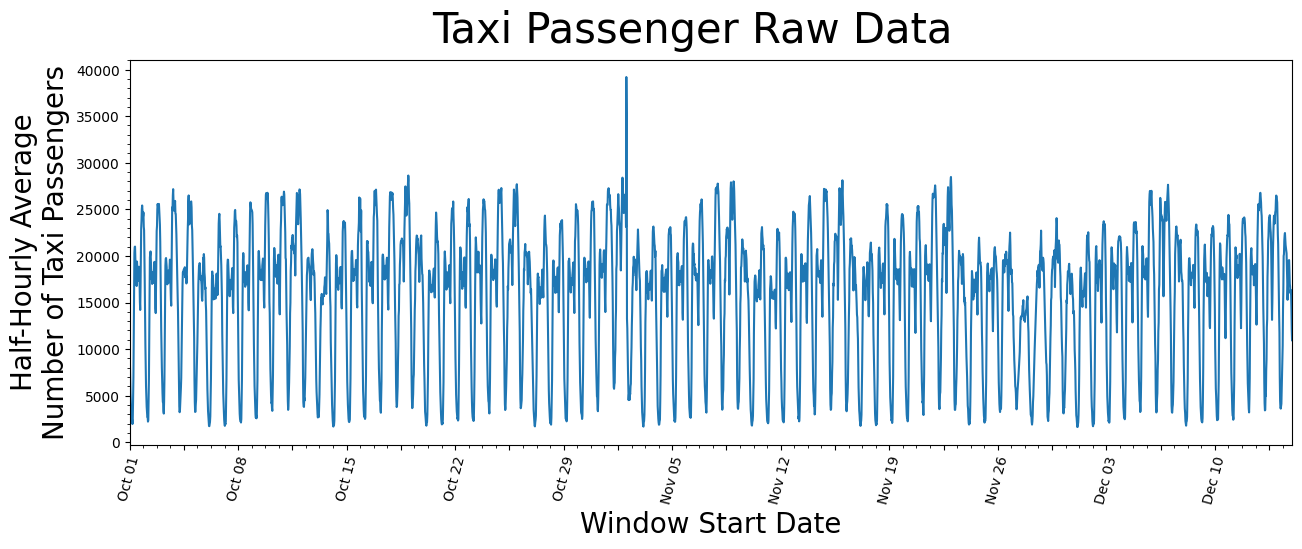

In [52]:
# This code is going to be utilized to control the axis labeling of the plots
DAY_MULTIPLIER = 7  # Specify for the amount of days you want between each labeled x-axis tick

x_axis_labels = taxi_df[(taxi_df.timestamp.dt.hour==0)]['timestamp'].dt.strftime('%b %d').values[::DAY_MULTIPLIER]
x_axis_labels[1::2] = " "
x_axis_labels, DAY_MULTIPLIER

# Plotting the raw data
plt.figure(figsize=(15,5))
plt.suptitle('Taxi Passenger Raw Data', fontsize='30')
plt.ylabel('Half-Hourly Average\nNumber of Taxi Passengers', fontsize='20')
plt.plot(taxi_df['value'])

plt.xticks(np.arange(0, taxi_df['value'].shape[0], (48*DAY_MULTIPLIER)/2), x_axis_labels)
plt.xticks(rotation=75)
plt.minorticks_on()
plt.margins(x=0)
plt.show()

# Apply Isolation Forest to Detect Anomalies
Apply the implemented Isolation Forest algorithm to the preprocessed time series data to detect anomalies.

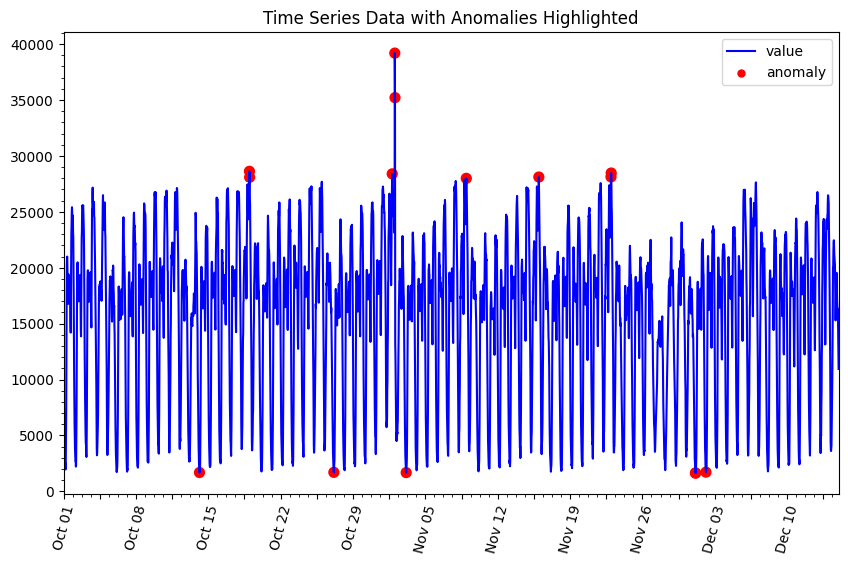

In [57]:
# Instantiate the Isolation Forest
iso_forest = IsolationForest(height_limit=8, num_trees=100)

# Fit the model to the data
X = taxi_df['value'].values.reshape(-1, 1)
iso_forest.fit(X)

# Compute anomaly scores
scores = iso_forest.anomaly_score(X)

# Predict anomalies in the data
predictions = iso_forest.predict(X, threshold=0.6)

# Add the scores and predictions to the dataframe
taxi_df['scores'] = scores
taxi_df['anomaly'] = predictions

# Plot the time series data and highlight the anomalies
plt.figure(figsize=(10, 6))
plt.plot(taxi_df.index, taxi_df['value'], label='value', color='blue')
plt.scatter(taxi_df.index, taxi_df['value'], label='anomaly', color='red', 
            s=taxi_df['anomaly'] * 50, edgecolors='red')
plt.title('Time Series Data with Anomalies Highlighted')
plt.legend()
plt.xticks(np.arange(0, taxi_df['value'].shape[0], (48*DAY_MULTIPLIER)/2), x_axis_labels)
plt.xticks(rotation=75)
plt.minorticks_on()
plt.margins(x=0)

plt.show()